In [1]:
#!git clone https://github.com/ZoneTsuyoshi/lock.git

In [2]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-

import math
import os
import sys
import matplotlib.pyplot as plt
from scipy import integrate

import numpy as np
xp = np
xp_type = "numpy"


sys.path.append("./lock/src")
from lock import LOCK
from emkf import ExpectationMaximizationKalmanFilter
from model import DampedOscillationModel
from scheme import EulerScheme

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
save_dir = "./results/custom_exp"

# make directory
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

# set parameters
def w(t):
    return 0
perf_initial = xp.array([5.0, 0.0])
sim_initial = xp.array([[6.0, 0.0]])
m = 1.0
k = 0.5
r = 0.52
dt = 1
obs_sd = 2
sys_sd = 0.7
T = 200
update_interval = 4
eta = 0.6
cutoff = 0.5
iteration = 5
seed = 121
xp.random.seed(seed)

In [4]:
# set matrix
F = np.array([[1, dt], [- k * dt / m, 1 - r * dt / m]])
G = np.array([[0], [dt / m]])
H = np.array([[1, 0], [0, 1]])
V0 = np.array([[1, 0], [0, 1]])
Q = np.array([[sys_sd**2]])
R = np.array([[obs_sd**2, 0], [0, obs_sd**2]])

In [5]:
dom = DampedOscillationModel(m, k, r, w)
es = EulerScheme(dt, T, dom, seed, xp_type)
true, obs = es.noise_added_simulation(perf_initial, sys_sd, obs_sd)

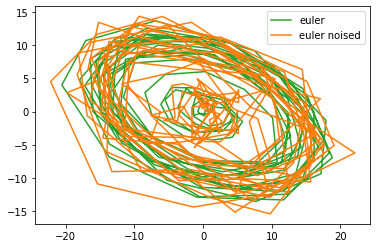

In [6]:
plt.plot(*true.T, label='euler', color='tab:green')
plt.plot(*obs.T, label='euler noised', color='tab:orange')
plt.legend()

In [7]:
lock = LOCK(observation = obs,
            transition_matrix = F,
            observation_matrix = H,
            transition_covariance = G @ Q @ G.T,
            observation_covariance = R,
            initial_mean = sim_initial,
            initial_covariance = V0,
            update_interval = update_interval,
            eta = eta,
            cutoff = cutoff,
            store_transition_matrices_on = True,
            use_gpu = False)
lock.forward()

emkf = ExpectationMaximizationKalmanFilter(observation = obs,
            transition_matrices = F,
            observation_matrices = H,
            transition_covariance = G @ Q @ G.T,
            observation_covariance = R,
            initial_mean = sim_initial,
            initial_covariance = V0,
            update_interval = update_interval,
            eta = eta,
            cutoff = cutoff,
            iteration = iteration,
            store_transition_matrices_on = True,
            use_gpu = False)
emkf.forward()

 expectation step calculating... t=4/4

 expectation step calculating... t=3/3

In [8]:
rm = np.zeros_like(obs)
N = 3
rm[:, 0] = np.convolve(obs[:, 0], np.ones(N)/N, mode='same')
rm[:, 1] = np.convolve(obs[:, 1], np.ones(N)/N, mode='same')

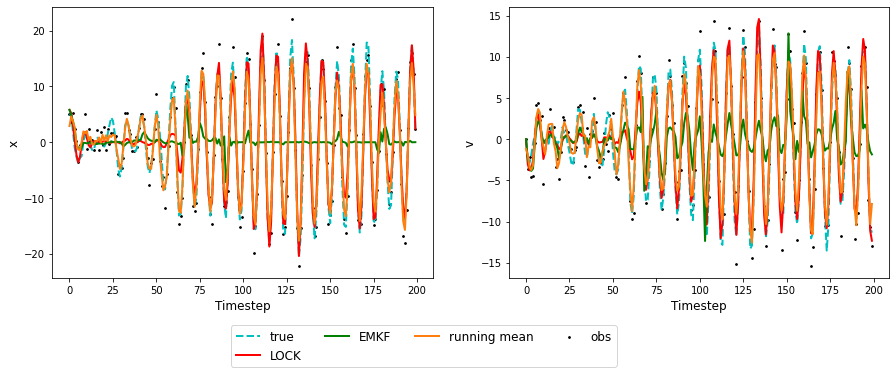

In [9]:
# plot filtered result regarding final execution
fig, axis = plt.subplots(1, 2, figsize=(15,5))
lw = 2
for i, value in enumerate(["x", "v"]):
    axis[i].plot(true[:,i], linestyle = '--', color = 'c', label = 'true', lw=lw)
    axis[i].plot(lock.get_filtered_value(i), color = 'r', label =  'LOCK', lw=lw)
    axis[i].plot(emkf.get_filtered_value(i), color = 'g', label =  'EMKF', lw=lw)
    axis[i].plot(rm[:,i], color = 'tab:orange', label = 'running mean', lw=lw)
    axis[i].scatter(range(T), obs[:,i], color = "k", marker = 'o', label = "obs", s=3)
    axis[i].set_xlabel('Timestep', fontsize=12)
    axis[i].set_ylabel(value, fontsize=12)
axis[0].legend(loc = 'upper right', bbox_to_anchor=(1.5, -0.15), ncol=4, fontsize=12)
fig.savefig(os.path.join(save_dir, "ex4_states.png"), bbox_inches="tight")

In [10]:
print(f"observed MSE: {np.mean((true - obs)**2):.3f}")
print(f"LOCK MSE: {np.mean((true - lock.get_filtered_value())**2):.3f}")
print(f"EMKF MSE: {np.mean((true - emkf.get_filtered_value())**2):.3f}")
print(f"running mean MSE: {np.mean((true - rm)**2):.3f}")

observed MSE: 4.097
LOCK MSE: 5.248
EMKF MSE: 56.331
running mean MSE: 3.177
